In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

% matplotlib inline
sns.set_context('poster')
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['lines.markeredgewidth'] = 2

In [171]:
# Load the training data
df_building = pd.read_csv('building_metadata.csv')
df_train = pd.read_csv('train.csv')
df_weather_train = pd.read_csv('weather_test.csv')

Let's take a look at the weather data...

In [172]:
df_weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [173]:
# Convert the timestamp to datatime and get the hour
df_weather_train['hour'] = pd.to_datetime(df_weather_train['timestamp'])
df_weather_train['hour'] = df_weather_train['hour'].apply(lambda x: x.hour)

We're not sure if the timestamps are the local time at each site, so we want to plot mean temperature per hour over the whole data set for each site. The peak of the air temperature should be at roughly the same local time each day.

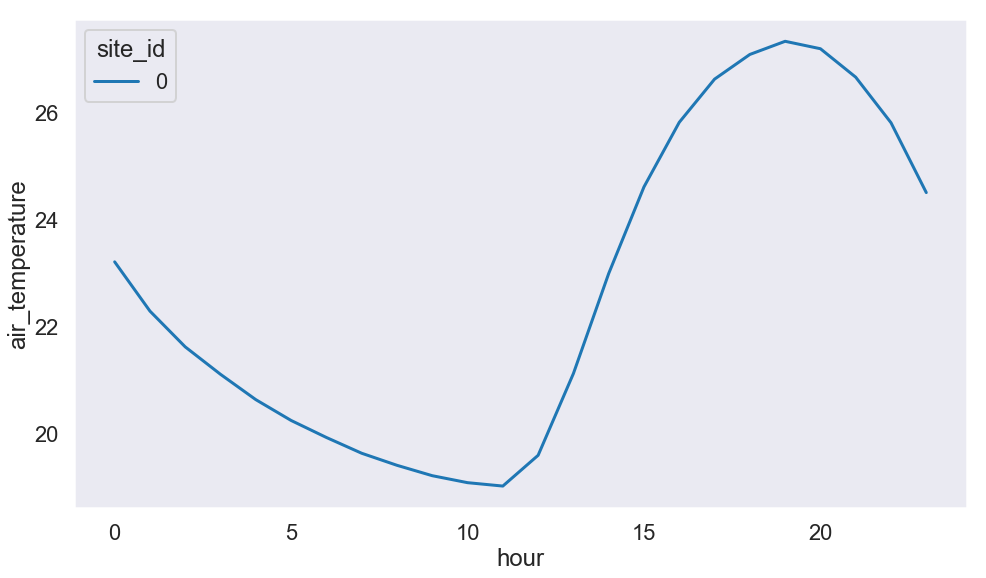

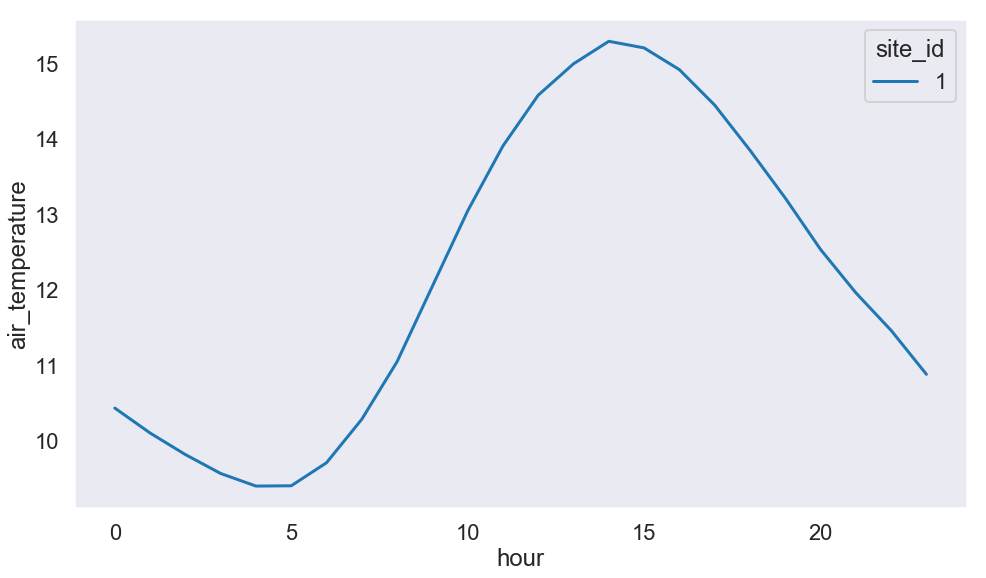

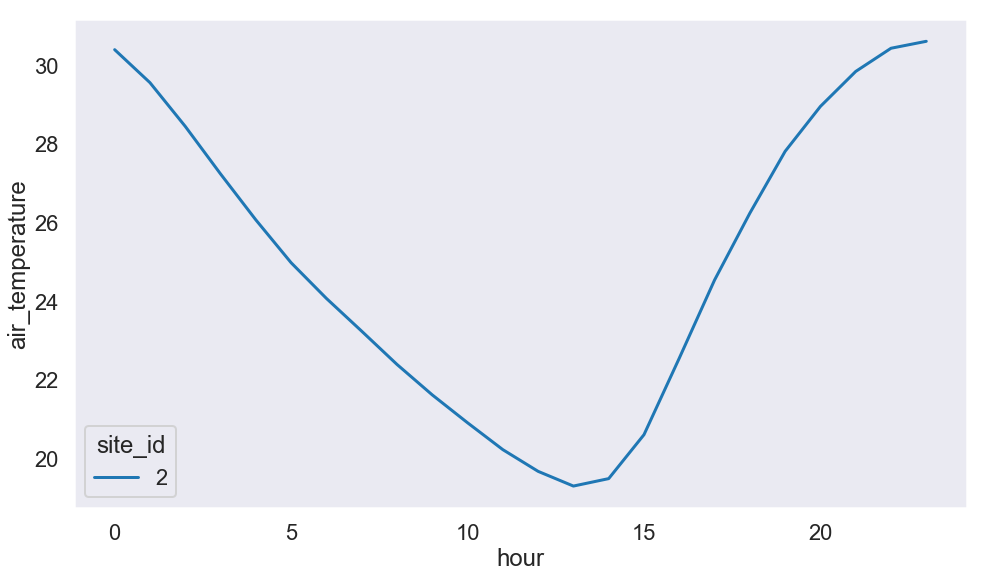

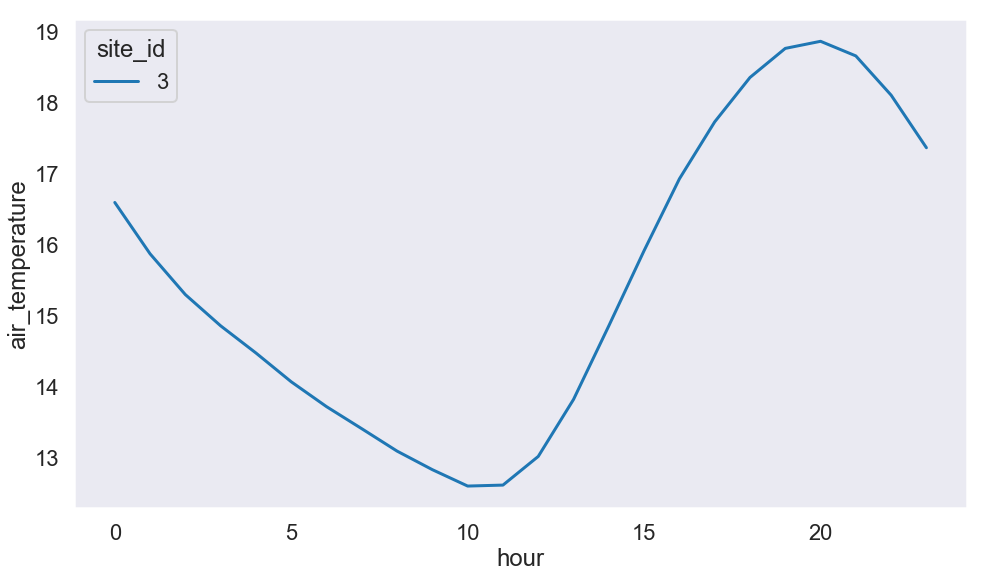

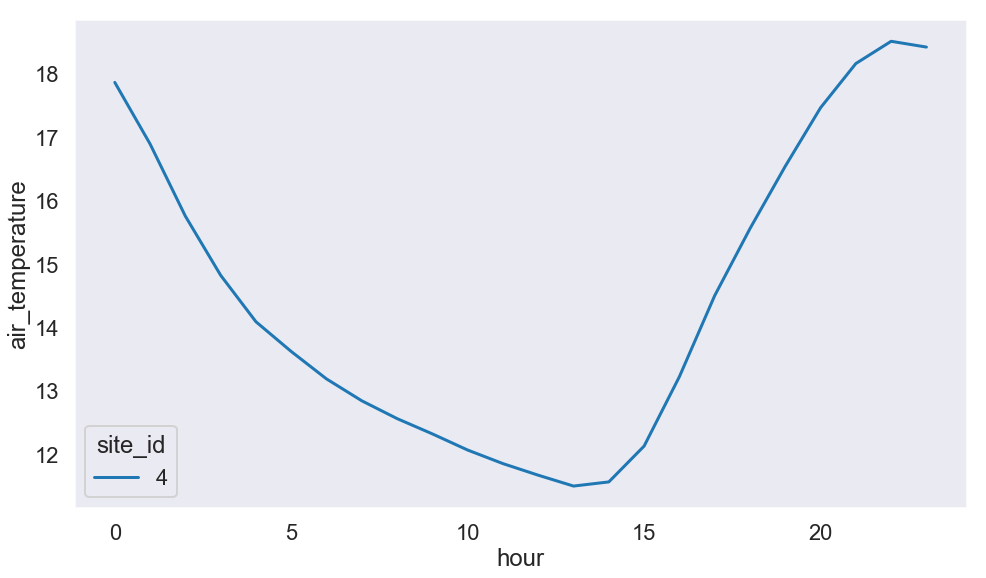

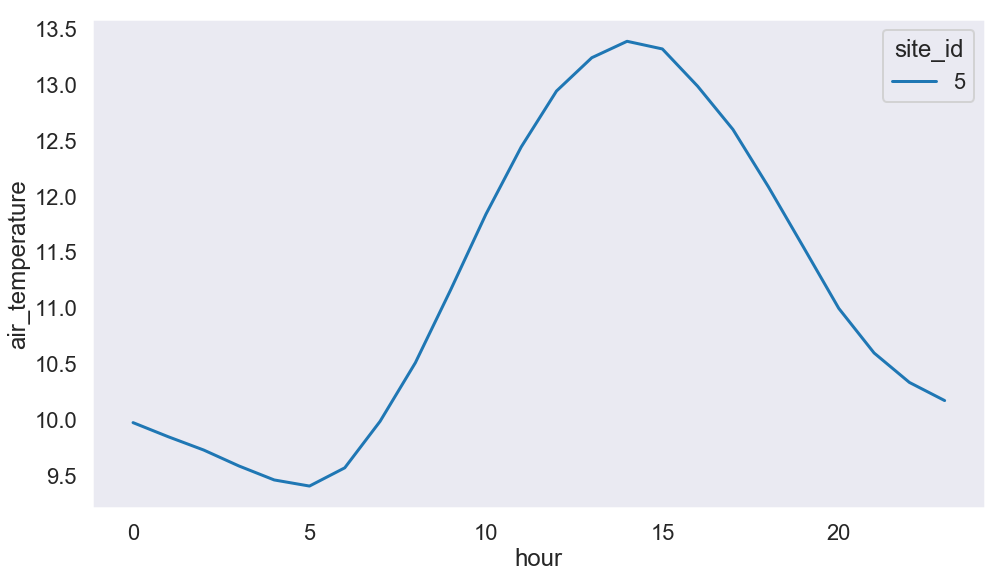

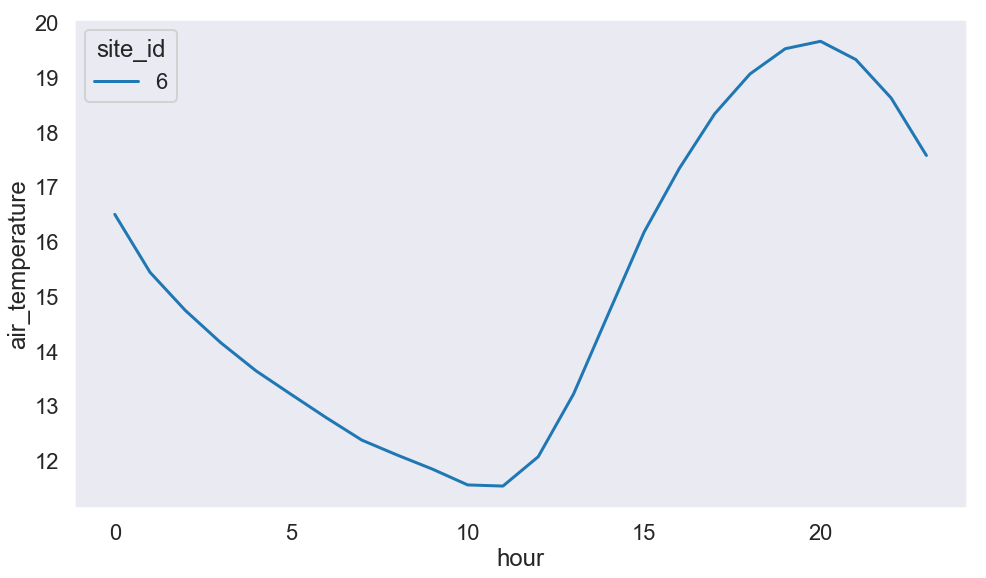

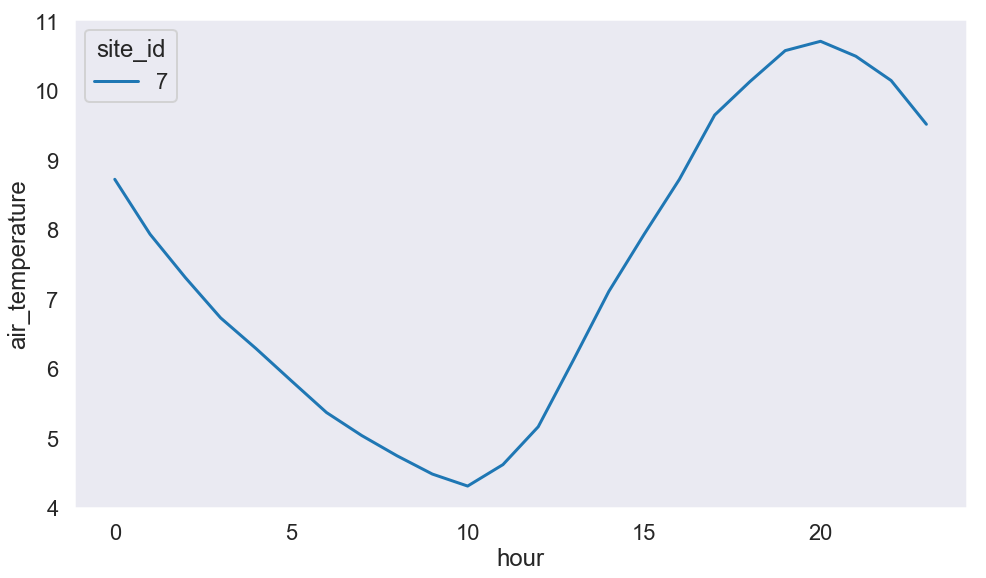

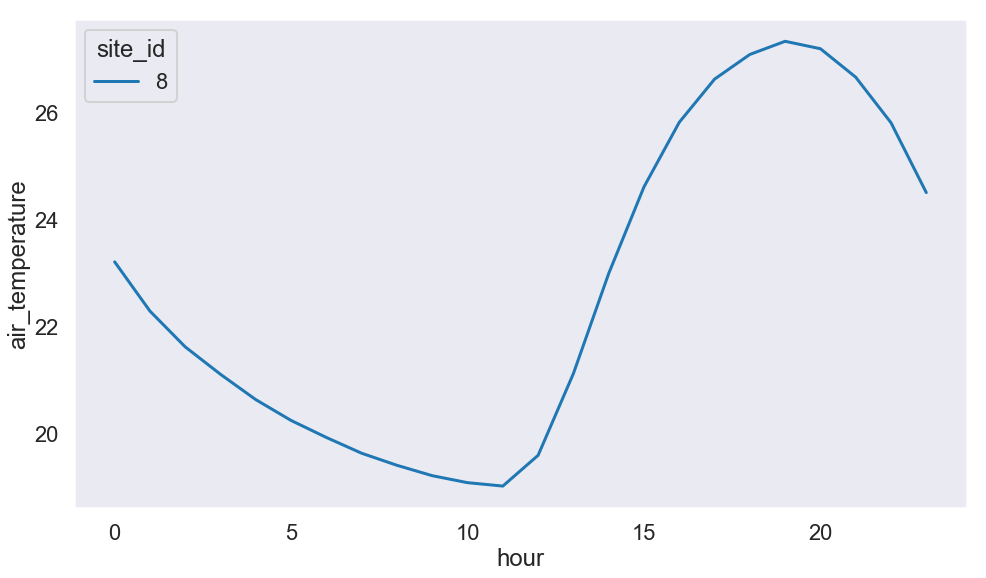

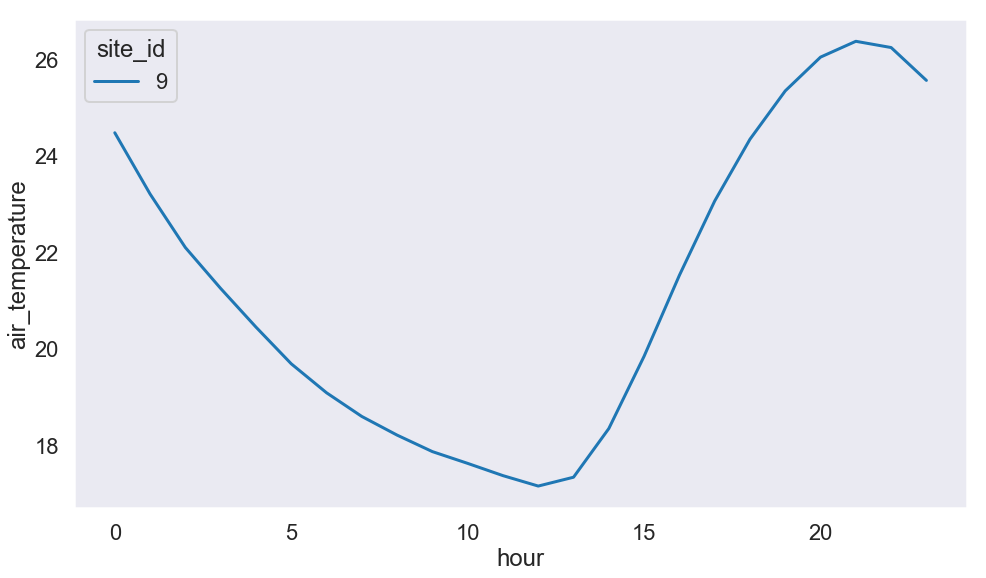

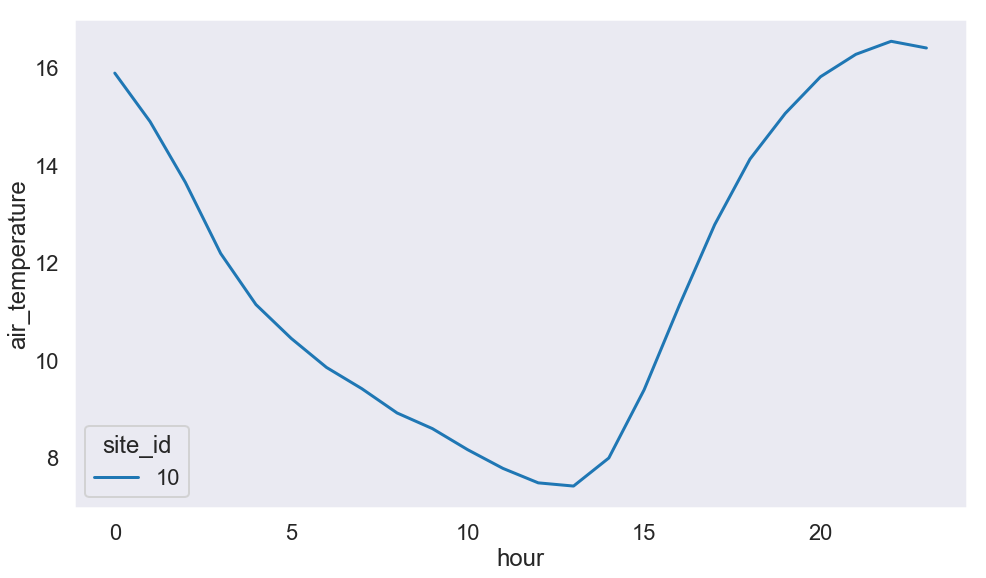

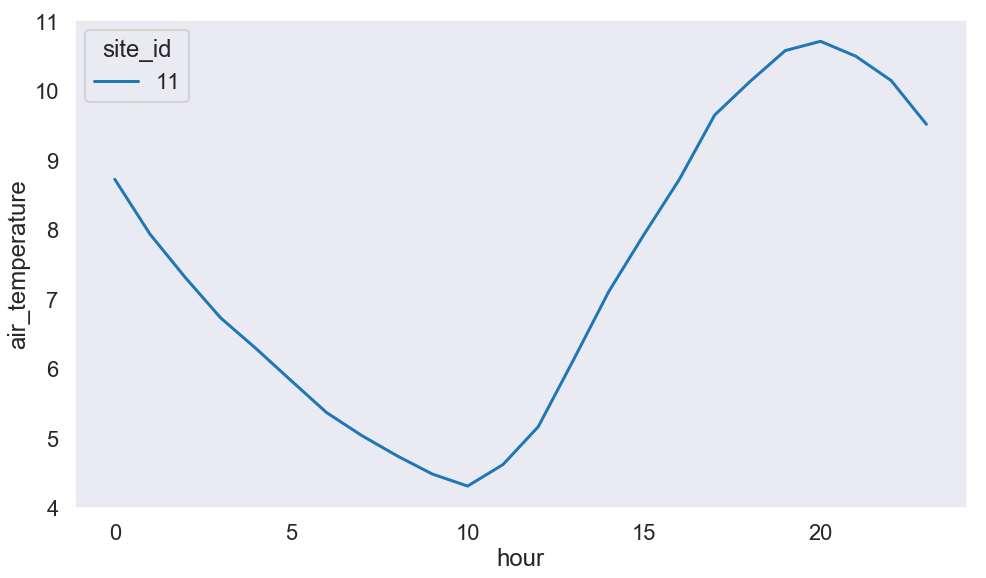

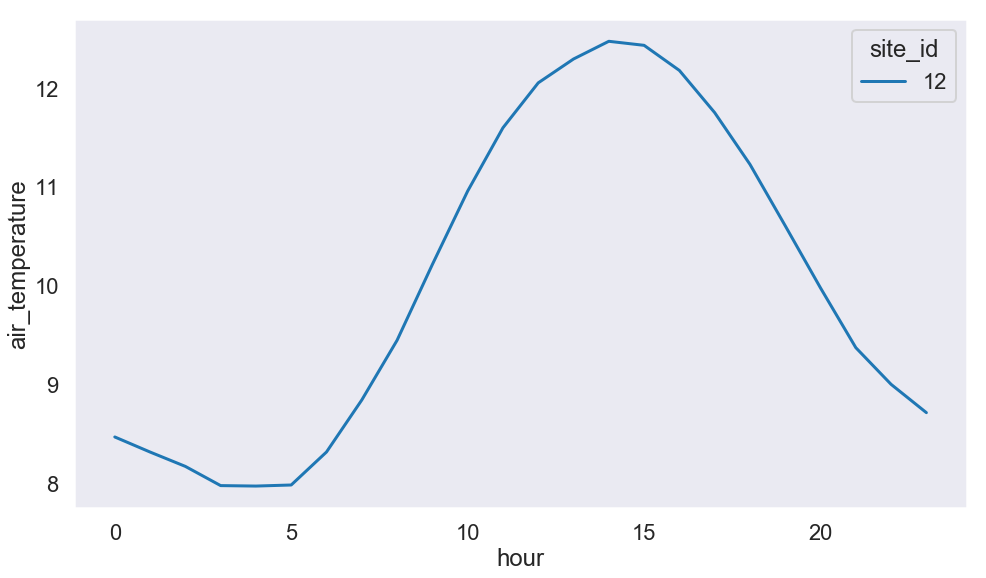

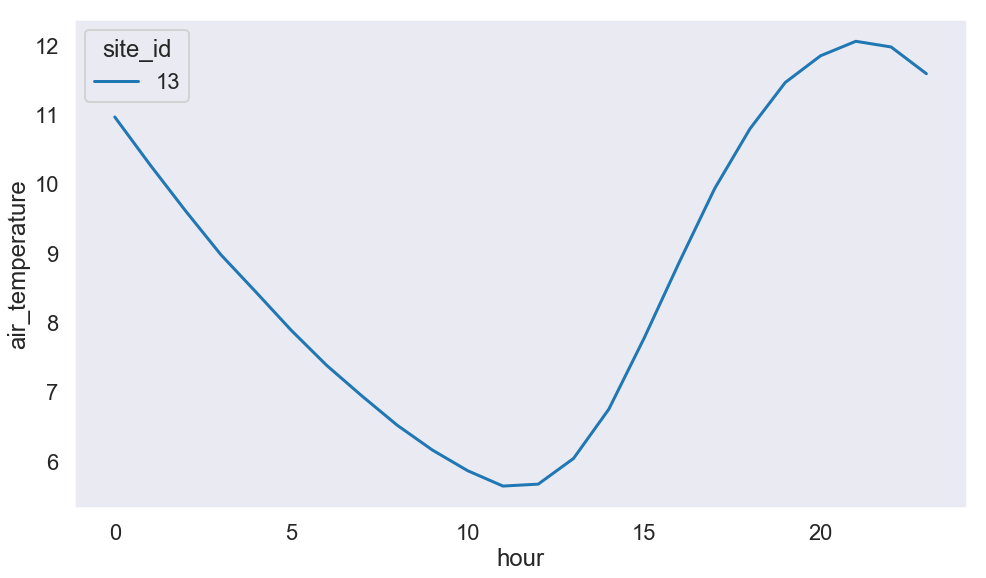

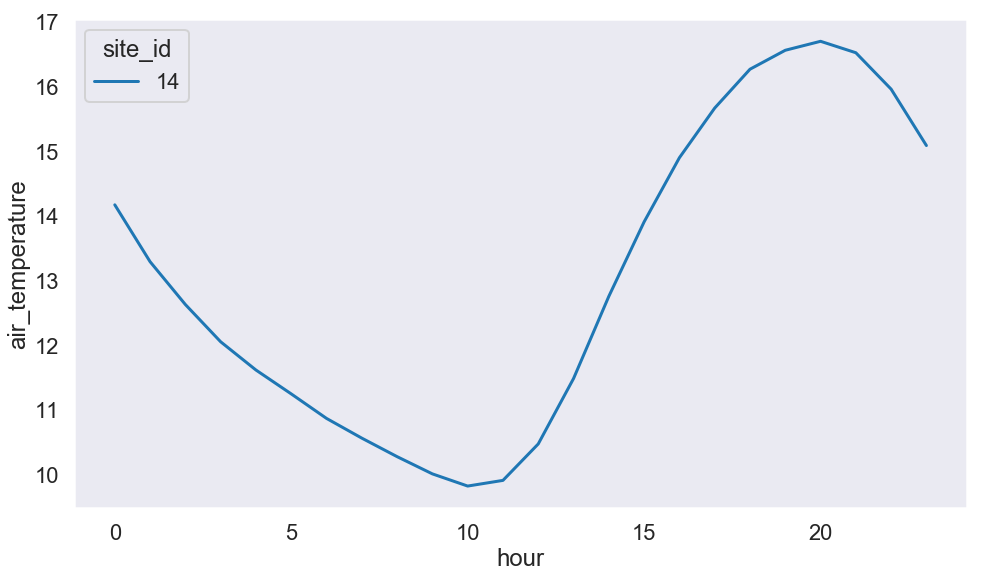

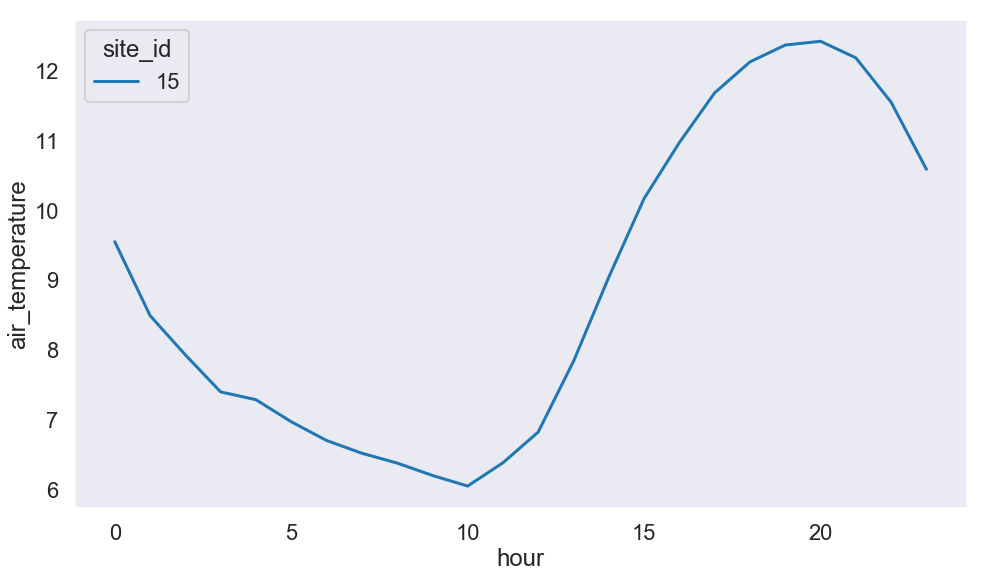

In [174]:
gb = df_weather_train.groupby(['site_id', 'hour'], as_index=False).mean()
for site_id in np.unique(gb['site_id']):
    site_mask = gb['site_id'] == site_id
    fig, ax = plt.subplots()
    ax.plot(gb['hour'][site_mask], gb['air_temperature'][site_mask], label=site_id)
    ax.set_xlabel('hour')
    ax.set_ylabel('air_temperature')
    ax.legend(title='site_id')

The peaks are not aligned, which indicates that the timestamps are probably not local. We can find the hour of the maximum temperature at each site, then shift the hour by the maximum in order to normalize the hours. This way they are all standardized and meaningful. 

In [175]:
# Find index of the hour of the maximum air temperature for each site 
max_idx = df_weather_train.groupby(['site_id', 'hour']).mean().groupby(['site_id'])['air_temperature'].idxmax()

In [176]:
# Shift the hours at each site by its the hour of the maximum air temperature
df_weather_train['hour_shifted'] = np.nan
gb = df_weather_train.groupby(['site_id', 'hour'])
max_hours = max_idx.apply(lambda x: x[1])
for s, max_hr in enumerate(max_hours):
    df_weather_train.loc[df_weather_train['site_id'] == s, 'hour_shifted'] = df_weather_train[df_weather_train['site_id'] == s]['hour'] - max_hr

In [177]:
# Find shifted hour modulus 24 to fix wrap around so that the maximum shifted hour is now at 0
df_weather_train['hour_shifted'] = df_weather_train['hour_shifted'] % 24

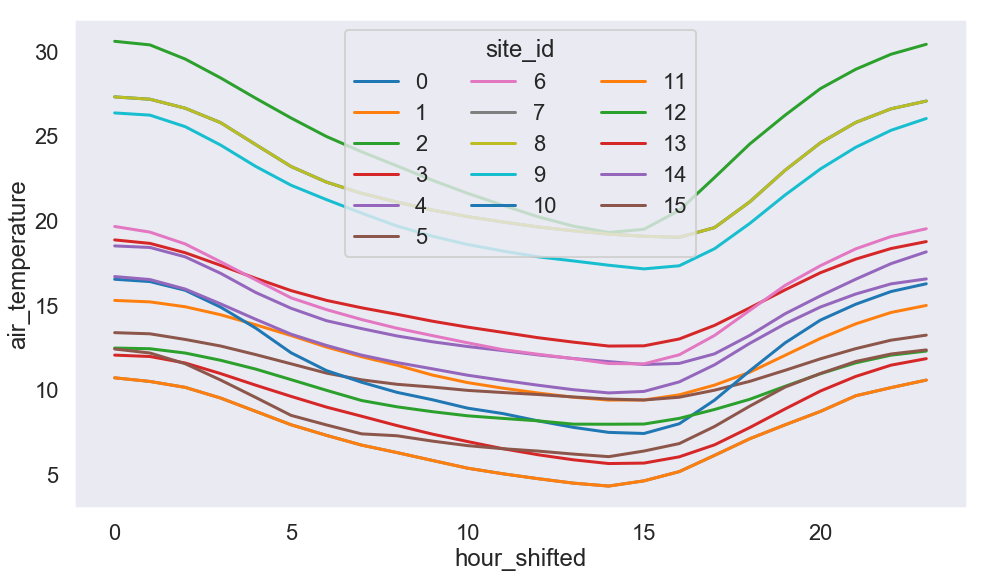

In [178]:
# Plot shifted hour vs air temperature at each site to see if it worked
gb = df_weather_train.groupby(['site_id', 'hour_shifted'], as_index=False).mean()
fig, ax = plt.subplots()
for site_id in np.unique(gb['site_id']):
    site_mask = gb['site_id'] == site_id
    ax.plot(gb['hour_shifted'][site_mask], gb['air_temperature'][site_mask], label=site_id)
    ax.set_xlabel('hour_shifted')
    ax.set_ylabel('air_temperature')
    ax.legend(title='site_id', ncol=3)

Let's join the datasets so we can look at the all of the data in aggregate

In [179]:
# Join the meter time series dataframe with the building metadata dataframe on building_id
df = df_train.join(df_building, on='building_id', how='left', rsuffix='_')

In [180]:
df_train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')

In [181]:
# Now join the combined dataframe from above with the weather dataframe on the site_id
df = df.join(df_weather_train, on='site_id', how='left', rsuffix='weather')

In [182]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,building_id_,primary_use,square_feet,year_built,floor_count,...,timestampweather,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,hour_shifted
0,0,0,2016-01-01 00:00:00,0.0,0,0,Education,7432,2008.0,NaN,...,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,5.0
1,1,0,2016-01-01 00:00:00,0.0,0,1,Education,2720,2004.0,NaN,...,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,5.0
2,2,0,2016-01-01 00:00:00,0.0,0,2,Education,5376,1991.0,NaN,...,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,5.0
3,3,0,2016-01-01 00:00:00,0.0,0,3,Education,23685,2002.0,NaN,...,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,5.0
4,4,0,2016-01-01 00:00:00,0.0,0,4,Education,116607,1975.0,NaN,...,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6,0,5.0
